In [2]:
import h5py
import numpy as np
from collections import defaultdict
import pandas as pd 

from plotting_tools import *

In [3]:
import os
os.getcwd()

'/home/nina/PycharmProjects/INSIDeMunich/analysis/scripts'

In [4]:
file_name = '99_output_v4.h5'
file_path = f"/media/nina/inside/memilio_output_28Apr/{file_name}"

In [5]:
def print_structure(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name}, shape: {obj.shape}, dtype: {obj.dtype}")
    elif isinstance(obj, h5py.Group):
        print(f"Group: {name}")

with h5py.File(file_path, 'r') as f:
    f.visititems(print_structure)

Group: data
Dataset: data/loc_ids, shape: (1536985, 2209), dtype: int32
Dataset: data/transm_recovery_tp, shape: (1536985, 2), dtype: float64


In [6]:
# Load the HDF5 file
with h5py.File(file_path, 'r') as f:
    group = f['data']
    
    # First dataset: infection and recovery times
    transmission_data = group['transm_recovery_tp'][:]  # shape: (#agents, 2)
    
    # Second dataset: location data
    location_data = group['loc_ids'][:]  # shape: (#agents, #timepoints)

### Number of Infections and Agents per tan Location

In [7]:
def get_infections_and_agents_per_location_and_timepoint(transmission_data, location_data):
    # Identify infected agents
    infected_mask = transmission_data[:, 0] < 100000
    infected_agents_indices = np.where(infected_mask)[0]

    # Determine number of timepoints
    num_timepoints = location_data.shape[1]

    # Infected agent counts: {(location, timepoint): count}
    location_time_counts = defaultdict(int)

    # Total agent counts: {(location, timepoint): count}
    total_location_time_counts = defaultdict(int)

    # --- Infected agent loop ---
    for agent_idx in infected_agents_indices:
        locations = location_data[agent_idx]
        for t in range(num_timepoints):
            if t < transmission_data[agent_idx, 0]:
                continue
            if t > transmission_data[agent_idx, 1]:
                break
            loc = locations[t]
            if loc > 0:
                location_time_counts[(loc, t)] += 1

    # --- All agent loop ---
    for agent_idx in range(location_data.shape[0]):
        locations = location_data[agent_idx]
        for t in range(num_timepoints):
            loc = locations[t]
            if loc > 0:
                total_location_time_counts[(loc, t)] += 1

    # --- Convert to DataFrames ---
    unique_locations = sorted(set(loc for (loc, _) in total_location_time_counts))
    timepoints = range(num_timepoints)

    # Infected DataFrame
    infections_df = pd.DataFrame(0, index=unique_locations, columns=timepoints)
    for (loc, t), count in location_time_counts.items():
        infections_df.loc[loc, t] = count

    # Total DataFrame
    total_df = pd.DataFrame(0, index=unique_locations, columns=timepoints)
    for (loc, t), count in total_location_time_counts.items():
        total_df.loc[loc, t] = count

    # Transpose for time along rows
    infections_df = infections_df.T
    total_df = total_df.T

    # Add date columns
    infections_df.reset_index(inplace=True)
    infections_df.rename(columns={'index': 'time_in_hours'}, inplace=True)
    infections_df["time_in_days"] = infections_df["time_in_hours"] / 24
    infections_df["Date"] = pd.to_datetime(infections_df["time_in_days"], unit='D', origin="2020-03-02 00:00:00")

    total_df.reset_index(inplace=True)
    total_df.rename(columns={'index': 'time_in_hours'}, inplace=True)
    total_df["time_in_days"] = total_df["time_in_hours"] / 24
    total_df["Date"] = pd.to_datetime(total_df["time_in_days"], unit='D', origin="2020-03-02 00:00:00")

    return infections_df, total_df


In [8]:
infections_df, total_df = get_infections_and_agents_per_location_and_timepoint(transmission_data, location_data)

In [9]:
infections_df.head()

,time_in_hours,1,3,4,5,7,9,10,11,12,...,236,237,238,239,240,241,242,243,time_in_days,Date
0,0,31,32,39,23,19,40,14,32,16,...,40,6,18,12,15,25,14,11,0.000000,2020-03-02 00:00:00.000000000
1,1,31,32,39,23,19,40,14,32,16,...,40,6,18,12,15,25,14,11,0.041667,2020-03-02 01:00:00.000000106
2,2,31,32,39,23,19,40,14,32,16,...,40,6,18,12,15,25,14,11,0.083333,2020-03-02 01:59:59.999999893
3,3,31,32,39,23,19,40,14,32,16,...,40,6,18,12,15,25,14,11,0.125000,2020-03-02 03:00:00.000000000
4,4,31,32,39,23,19,40,14,32,16,...,40,6,18,12,15,25,14,11,0.166667,2020-03-02 04:00:00.000000106


In [10]:
total_df.head()

,time_in_hours,1,3,4,5,7,9,10,11,12,...,236,237,238,239,240,241,242,243,time_in_days,Date
0,0,7184,8946,8355,5448,5194,11195,2927,5941,4084,...,11130,2821,4978,2754,2848,5233,2584,4087,0.000000,2020-03-02 00:00:00.000000000
1,1,7184,8946,8355,5448,5194,11195,2927,5941,4084,...,11130,2821,4978,2754,2848,5233,2584,4087,0.041667,2020-03-02 01:00:00.000000106
2,2,7184,8946,8355,5448,5194,11195,2927,5941,4084,...,11130,2821,4978,2754,2848,5233,2584,4087,0.083333,2020-03-02 01:59:59.999999893
3,3,7184,8946,8355,5448,5194,11195,2927,5941,4084,...,11130,2821,4978,2754,2848,5233,2584,4087,0.125000,2020-03-02 03:00:00.000000000
4,4,7184,8946,8355,5448,5194,11195,2927,5941,4084,...,11130,2821,4978,2754,2848,5233,2584,4087,0.166667,2020-03-02 04:00:00.000000106


In [11]:
def plot_total_number_of_agents(total_df, tan_loc):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(total_df["Date"], total_df[tan_loc], label=f"Location {tan_loc}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Agents [#]")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))  # Format without year
    plt.title(f"Agents over time for location {tan_loc}")

In [12]:
def plot_infection_fraction_over_time(infections_df, total_df, tan_loc):
    """
    Plot the number of infections over time for a specific location.
    """

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(infections_df["Date"], infections_df[tan_loc]/total_df[tan_loc], label=f"Location {tan_loc}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Infected Agents [fraction]")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))  # Format without year
    plt.title(f"Infections over time for location {tan_loc}")


In [18]:
def plot_infections_over_time(infections_df, tan_loc):
    """
    Plot the number of infections over time for a specific location.
    """

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(infections_df["Date"], infections_df[tan_loc], label=f"Location {tan_loc}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Infected Agents [#]")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))  # Format without year
    plt.title(f"Infections over time for location {tan_loc}")


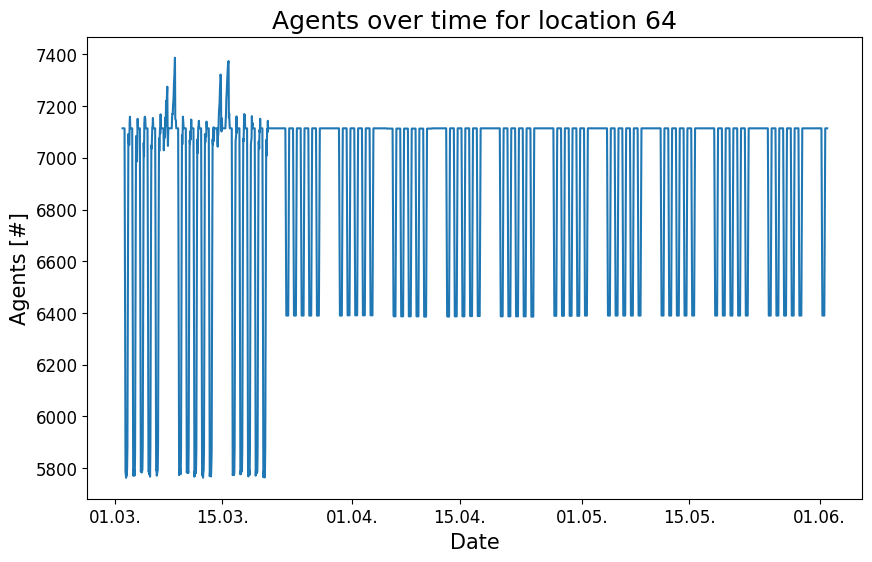

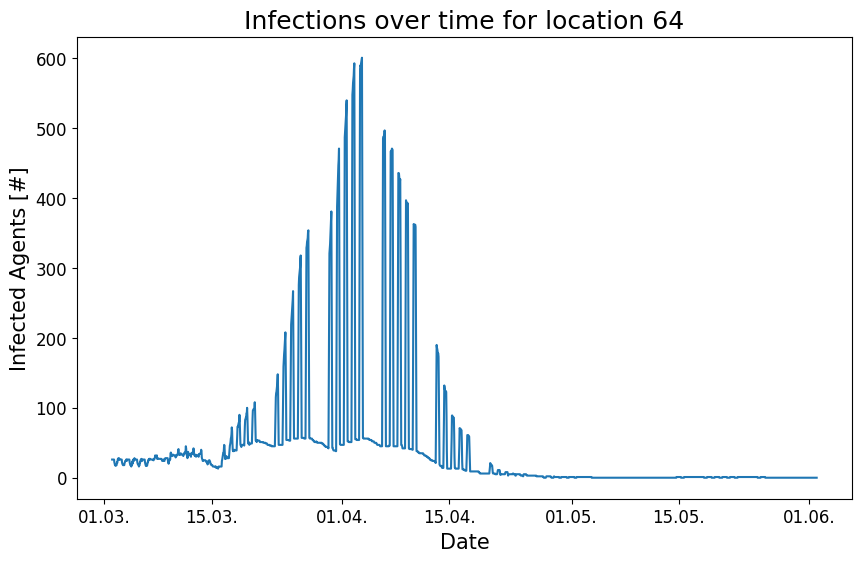

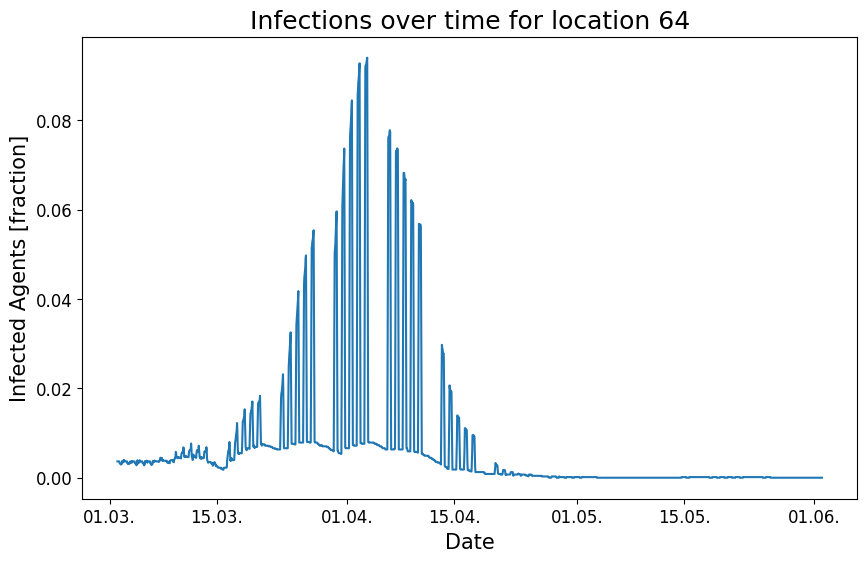

In [19]:
plot_total_number_of_agents(total_df, 64)

plot_infections_over_time(infections_df, 64)

plot_infection_fraction_over_time(infections_df,  total_df, 64)


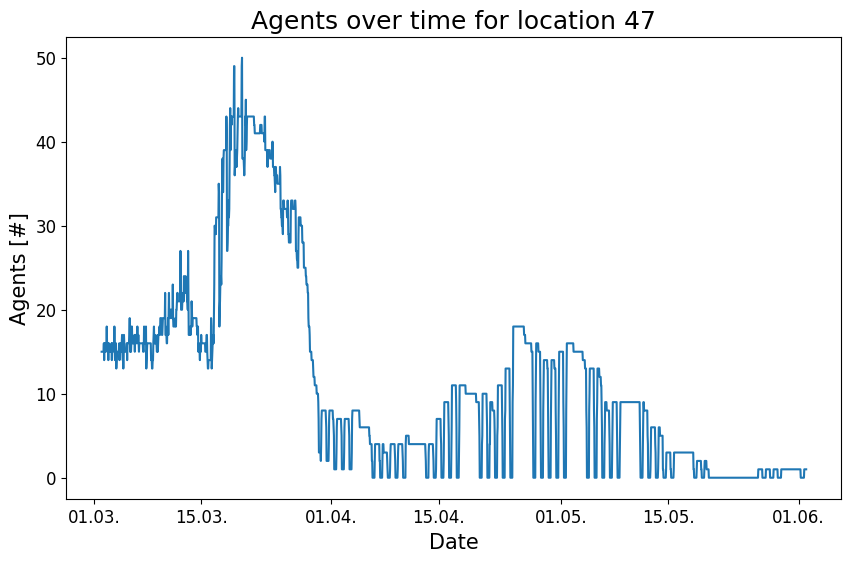

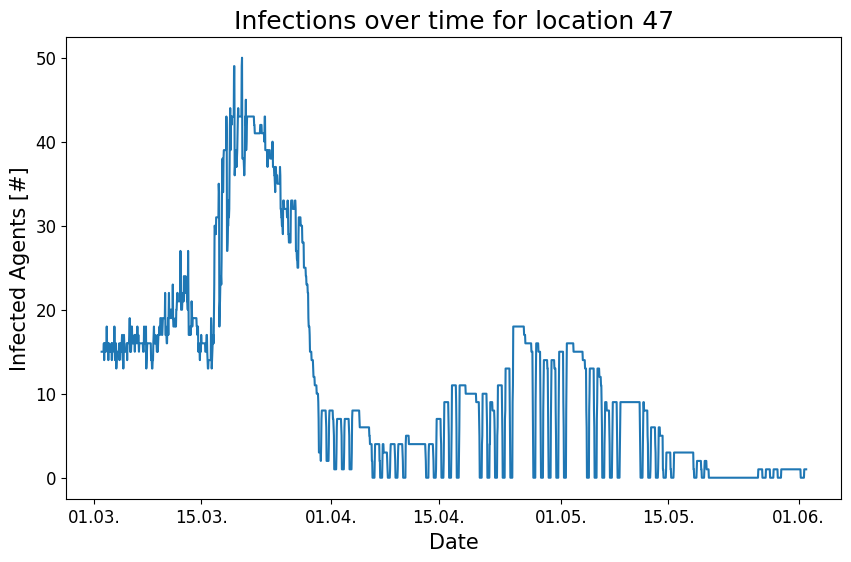

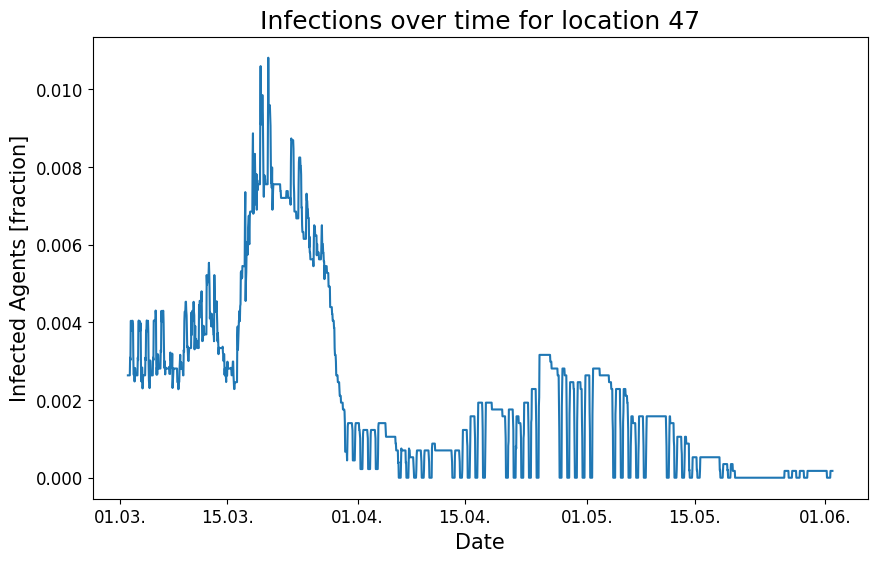

In [20]:
plot_total_number_of_agents(infections_df, 47)

plot_infections_over_time(infections_df, 47)

plot_infection_fraction_over_time(infections_df,  total_df, 47)


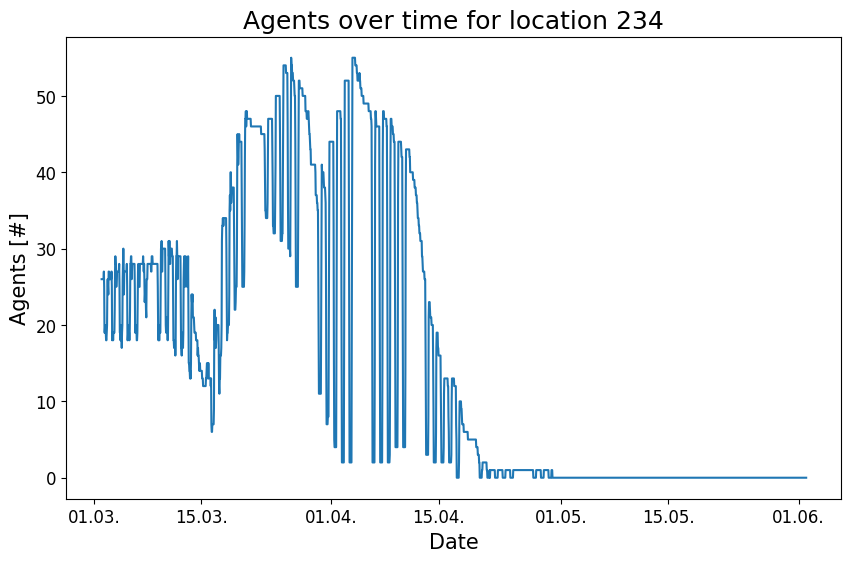

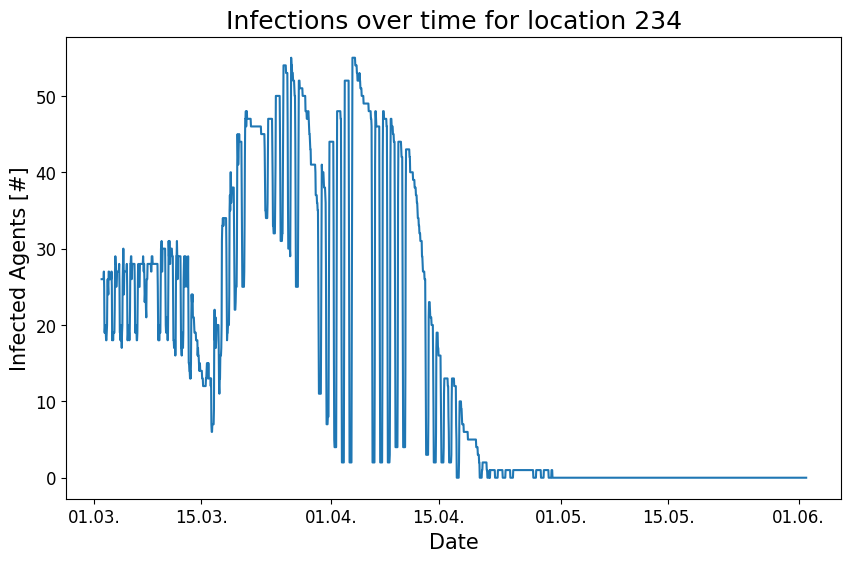

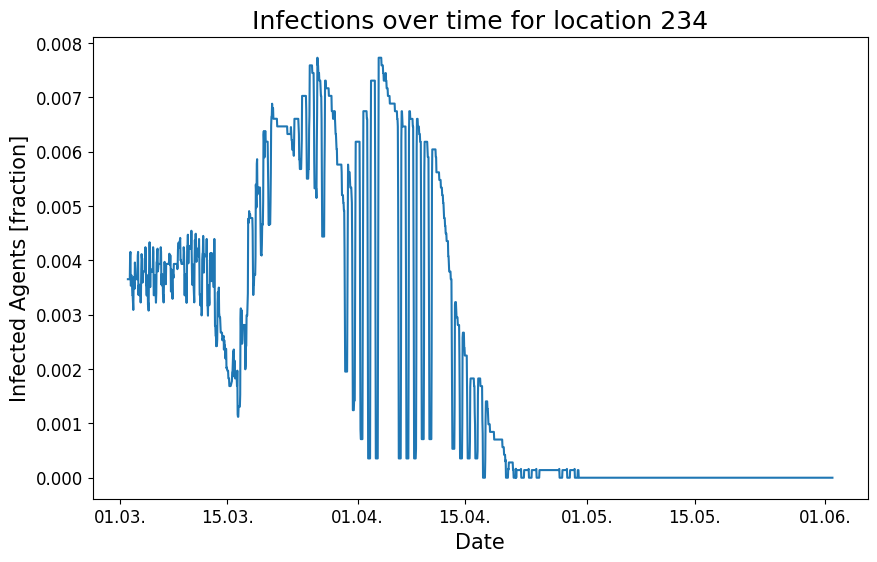

In [21]:
plot_total_number_of_agents(infections_df, 234)

plot_infections_over_time(infections_df, 234)

plot_infection_fraction_over_time(infections_df,  total_df, 234)


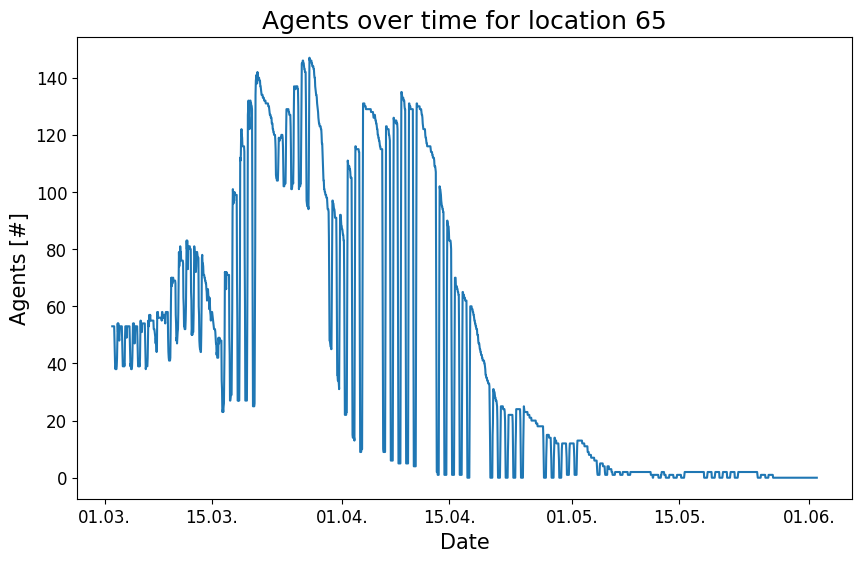

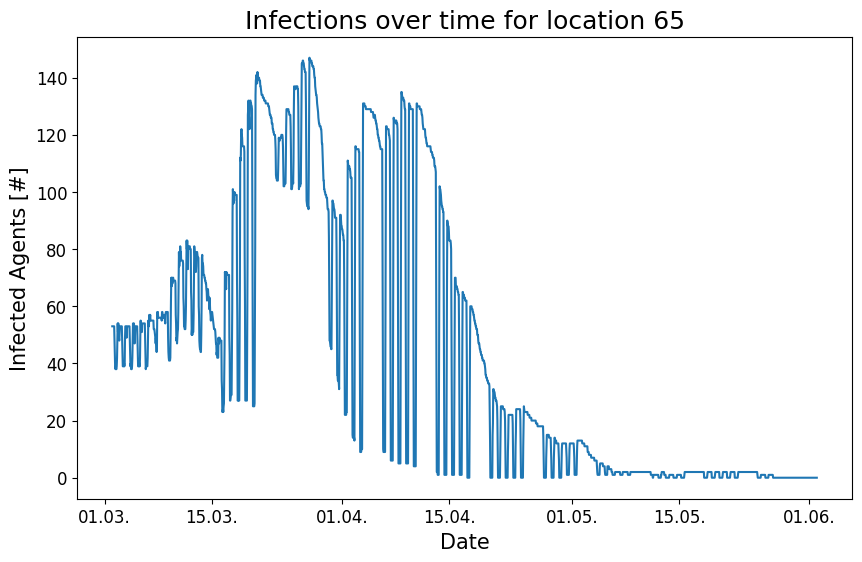

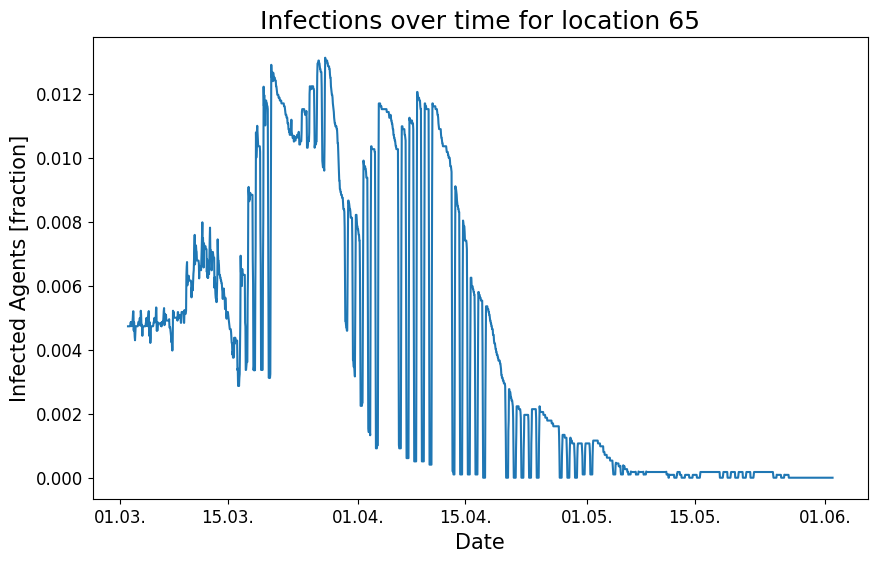

In [22]:
plot_total_number_of_agents(infections_df, 65)

plot_infections_over_time(infections_df, 65)

plot_infection_fraction_over_time(infections_df,  total_df, 65)
